# 🔬 Contrastive Scaling Laws in Diffusivity Using Neural Networks



## ✨ Abstract

**Contrastive Deep Learning for Generative Simulation (Contrastive GS)** is developed to support fast reasoning when simulation datasets are incomplete or when kernels cannot directly provide an answer to complex engineering or scientific questions. This lecture demonstrates how a neural network can recover **physically meaningful scaling laws** for molecular **diffusivity in polymers**, based only on contrastive ratios. Diffusivity, typically modeled through hole-free volume theory, is governed by temperature, molecular weight, and polymer state (e.g., rubbery vs. glassy).

We show that contrastive deep learning can bridge symbolic physical kernels and black-box inference methods by reconstructing embedded scaling laws from relative data. A neural network is compared with symbolic regression baselines and evaluated through visual diagnostics and dimensionality reduction.




## 1. 🧠 Theoretical Background

  - Diffusivity $D$ of a molecule in a polymer can be modeled as:
    $$
    \frac{D}{D_0} = \left(\frac{M}{M_0}\right)^{-\alpha(T,T_g)}
    $$

    $$
    \text{with} \quad \alpha(T,T_g) = 1 + \frac{K_a}{K_b + r(T - T_g)}
    $$

      - $M$: molecular weight of the substance

      - $M_0$, $D_0$: reference values

      - $T$: temperature in K, $T_g$: glass transition temperature

      - $r$: state parameter ($r=1$ in rubbery state)

      - $K_a \approx 140$ K, $K_b \approx 40$ K (rough estimates here)

        

> 📚 **References:**
>
> These models are not foundational in a unified theory of mass transport in glassy and rubber polymers based on free volume, cohesive energy, and thermodynamic fluctuations. They are described in detail in:
>
> 1.  Xiaoyi Fang, Sandra Domenek, Violette Ducruet, Matthieu Réfrégiers, and Olivier Vitrac.  
>     *Diffusion of Aromatic Solutes in Aliphatic Polymers above Glass Transition Temperature.*  
>     **Macromolecules**, 2013, **46** (3), 874–888.  
>     https://doi.org/10.1021/ma3022103
> 2.  Yan Zhu, Frank Welle, and Olivier Vitrac.  
>     *A Blob Model to Parameterize Polymer Hole Free Volumes and Solute Diffusion.*  
>     **Soft Matter**, 2019, **15**, 8912–8932.  
>     https://doi.org/10.1039/C9SM01556F


---

## 2. 🧪 Synthetic Data Generation

We simulate diffusivity for two polymers (PP and HDPE) with prescribed $tT_g$ by computing $D$ across a grid of molecular weights $M$ and temperatures $T$.

 For each combination of $M$ and $T$, we compute:

$D = D_0 \left(\frac{M}{M_0}\right)^{-\alpha(T,Tg)}$


### General Configuration

In [1]:
# Generic configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# add headtail() method to pd
def headtail(self,n=10):
    if self.shape[0] <= 2 * n:
        return self._repr_html_()
    else:
        top = self.head(n)
        bottom = self.tail(n)
        ellipsis = pd.DataFrame([["..."] * self.shape[1]], columns=self.columns)
        combined = pd.concat([top, ellipsis, bottom])
        return combined._repr_html_()

pd.DataFrame.headtail = headtail

# extra pd control
pd.set_option("display.max_rows", 100)        # Show more rows
pd.set_option("display.max_columns", 20)      # Show more columns
pd.set_option("display.width", 1000)          # Set display width
pd.set_option("display.float_format", "{:.3g}".format)  # Format floats

# plot configuration
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'figure.dpi': 300}
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

### Data Generation

In [2]:
# Ka, Kb, M0, D0, and Tg defined above
# Produces a dataset df with columns: Polymer, M, T, alpha, Dimport numpy as np

# Constants for the scaling law
Ka, Kb = 140, 40  # K

# Polymers with their Tg and r values
polymers = {
    'PP': {'Tg': 273, 'r': 1.0},
    'HDPE': {'Tg': 173, 'r': 1.0}
}

# Reference values
M0, D0 = 100, 1e-9  # g/mol, m²/s <-- arbitrary reference

# Generate a grid of M and T values
M_values = np.linspace(40, 500, 7)  # g/mol
T_values_C = np.linspace(23, 100, 7)  # °C
T_values = T_values_C + 273.15  # Convert to Kelvin

# Generate synthetic data
data = []

for polymer, props in polymers.items():
    Tg = props['Tg']
    r = props['r']
    for M in M_values:
        for T in T_values:
            alpha = 1 + Ka / (Kb + r * (T - Tg))
            D = D0 * (M / M0) ** (-alpha)
            data.append({
                'Polymer': polymer,
                'M': M,
                'T': T,
                'T_C': T - 273.15,
                'Tg': Tg,
                'alpha': alpha,
                'D': D
            })

df = pd.DataFrame(data)

# print df overview
display(HTML(df.headtail(10)))
#print(df.headtail(10))

,Polymer,M,T,T_C,Tg,alpha,D
0,PP,40,296,23,273,3.22,1.91e-08
1,PP,40,309,35.8,273,2.84,1.35e-08
2,PP,40,322,48.7,273,2.58,1.06e-08
3,PP,40,335,61.5,273,2.38,8.83e-09
4,PP,40,347,74.3,273,2.22,7.67e-09
5,PP,40,360,87.2,273,2.1,6.85e-09
6,PP,40,373,100,273,2,6.24e-09
7,PP,117,296,23,273,3.22,6.09e-10
8,PP,117,309,35.8,273,2.84,6.45e-10
9,PP,117,322,48.7,273,2.58,6.72e-10


---
## 3. 🔁 Contrastive Dataset Construction

Instead of absolute diffusivities, we focus on **pairwise contrastive ratios**:

$y = \log\left(\frac{D_i}{D_j}\right) = -\alpha \cdot \log\left(\frac{M_i}{M_j}\right)$

**Contrastive features:**

- $x_1 = \log(M_i/M_j)$
- $x_2 = 1/T_i - 1/T_j$
- $x_3 = T_{g,i} - T_{g,j}$
- $y = \log(D_i/D_j)$

In [3]:
# Generates contrastive_df with inputs and log-ratio targets
# %% Contrastive Data
from itertools import combinations

# Create contrastive pairs
df['logD'] = np.log(df['D'])
contrastive_data = []

for polymer in df['Polymer'].unique():
    subset = df[df['Polymer'] == polymer].reset_index(drop=True)
    for i, j in combinations(range(len(subset)), 2):
        row_i = subset.loc[i]
        row_j = subset.loc[j]

        logD_ratio = row_i['logD'] - row_j['logD']
        logM_ratio = np.log(row_i['M'] / row_j['M'])
        invT_diff = (1 / row_i['T']) - (1 / row_j['T'])
        Tg_diff = row_i['Tg'] - row_j['Tg']

        contrastive_data.append({
            'Polymer': polymer,
            'logM_ratio': logM_ratio,
            'invT_diff': invT_diff,
            'Tg_diff': Tg_diff,
            'logD_ratio': logD_ratio
        })

contrastive_df = pd.DataFrame(contrastive_data)

print(f"Generated {len(contrastive_df)} contrastive pairs")
pd.set_option("display.max_rows", 20)

display(HTML(contrastive_df.headtail(10)))
#print(contrastive_df.headtail(10))

Generated 2352 contrastive pairs


,Polymer,logM_ratio,invT_diff,Tg_diff,logD_ratio
0,PP,0,0.00014,0,0.343
1,PP,0,0.000269,0,0.587
2,PP,0,0.000388,0,0.769
3,PP,0,0.000499,0,0.911
4,PP,0,0.000601,0,1.02
...,...,...,...,...,...
2347,HDPE,0,0.000213,0,-0.126
2348,HDPE,0,0.000308,0,-0.179
2349,HDPE,0,0.000102,0,-0.0593
2350,HDPE,0,0.000198,0,-0.112


---
## 4. 🤖 Neural Network Training

### Utility function for calculating residuals and their statistics

In [37]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def compute_residuals(y_true, y_pred):
    y_true = y_true.copy().ravel()
    y_pred = y_pred.copy().ravel()
    residuals = y_pred - y_true
    return {
        "actual": y_true,
        "predicted": y_pred,
        "residuals": residuals,
        "mean": residuals.mean(),
        "std": residuals.std(),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "min": residuals.min(),
        "max": residuals.max(),
        "r2": r2_score(y_true, y_pred)
    }

# initialization of the container dict
diagnostics = {
    "NN": {
        "train": {},
        "test": {}
    },
    "poly": {
        "train": {},
        "test": {}
    }
}


### ANN model
We train a *small* 3-layer feedforward neural network on the scaled contrastive features.

**Model:** 3 inputs → 32 ReLU → 32 ReLU → 1 output

> Change nNN to test different values

Contrastive NN R² score (train): 0.8884
Contrastive NN R² score (test): 0.8886


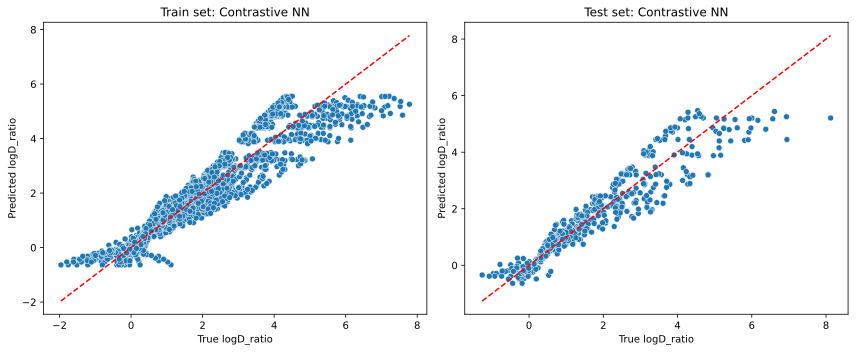

In [38]:
# PyTorch model training with MSELoss over 500 epochs
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# ----- Preprocessing -----
X = contrastive_df[['logM_ratio', 'invT_diff', 'Tg_diff']].values
y = contrastive_df['logD_ratio'].values.reshape(-1, 1)
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Split the contrastive_df into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=0)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ----- Neural Network -----
nNN = 32
class ContrastiveNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, nNN),
            nn.ReLU(),
            nn.Linear(nNN, nNN),
            nn.ReLU(),
            nn.Linear(nNN, 1)
        )

    def forward(self, x):
        return self.net(x)

model = ContrastiveNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# ----- Training Loop -----
for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    loss.backward()
    optimizer.step()

# ----- Evaluation and inverse transform -----
model.eval()
with torch.no_grad():
    y_train_pred_scaled = model(X_train_tensor).numpy()
    y_test_pred_scaled = model(X_test_tensor).numpy()

    # Inverse scaling
    y_train_pred_NN = y_scaler.inverse_transform(y_train_pred_scaled)
    y_test_pred_NN = y_scaler.inverse_transform(y_test_pred_scaled)
    y_train_true = y_scaler.inverse_transform(y_train)
    y_test_true = y_scaler.inverse_transform(y_test)

# ----- R² scores -----
r2_train_nn = r2_score(y_train_true, y_train_pred_NN)
r2_test_nn = r2_score(y_test_true, y_test_pred_NN)

print(f"Contrastive NN R² score (train): {r2_train_nn:.4f}")
print(f"Contrastive NN R² score (test): {r2_test_nn:.4f}")

# Fill diagnostics for NN
diagnostics["NN"]["train"] = compute_residuals(y_train_true, y_train_pred_NN)
diagnostics["NN"]["test"] = compute_residuals(y_test_true, y_test_pred_NN)


# ----- Plotting -----
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Train set
sns.scatterplot(x=y_train_true.ravel(), y=y_train_pred_NN.ravel(), ax=axs[0])
axs[0].plot([y_train_true.min(), y_train_true.max()], [y_train_true.min(), y_train_true.max()], 'r--')
axs[0].set_title("Train set: Contrastive NN")
axs[0].set_xlabel("True logD_ratio")
axs[0].set_ylabel("Predicted logD_ratio")

# Test set
sns.scatterplot(x=y_test_true.ravel(), y=y_test_pred_NN.ravel(), ax=axs[1])
axs[1].plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'r--')
axs[1].set_title("Test set: Contrastive NN")
axs[1].set_xlabel("True logD_ratio")
axs[1].set_ylabel("Predicted logD_ratio")

plt.tight_layout()
plt.savefig("assets/Dfig01.svg", format='svg', dpi=300)
plt.show()


---
## 5. 🔢 Symbolic Regression Baseline

We fit a degree-2 polynomial regression as a symbolic benchmark on the same dataset.

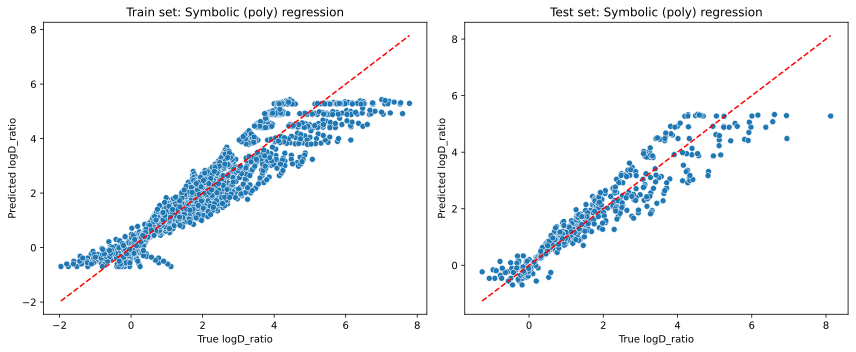

Contrastive NN R² score (train): 0.8866
Contrastive NN R² score (test): 0.8912


In [39]:
# %% symbolic regression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Split the contrastive_df into training and test sets
#train_df, test_df = train_test_split(contrastive_df, test_size=0.2, random_state=0)
# Training data
#X_train = train_df[['logM_ratio', 'invT_diff', 'Tg_diff']].values
#y_train = train_df['logD_ratio'].values
# Test data
#X_test = test_df[['logM_ratio', 'invT_diff', 'Tg_diff']].values
#y_test = test_df['logD_ratio'].values

# Use preprocessed and scaled data from earlier (same as NN)
# X_train, X_test, y_train, y_test already exist

# Symbolic regression surrogate: polynomial regression
# Regression pipeline (degree-2 polynomial regression)
poly_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)
poly_model.fit(X_train, y_train)

# Predict on scaled data
y_train_pred_poly = y_scaler.inverse_transform(poly_model.predict(X_train))
y_test_pred_poly = y_scaler.inverse_transform(poly_model.predict(X_test))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Training set
#sns.scatterplot(x=y_train, y=y_train_pred, ax=axs[0])
sns.scatterplot(x=y_train_true.ravel(), y=y_train_pred_poly.ravel(), ax=axs[0])
axs[0].plot([y_train_true.min(), y_train_true.max()], [y_train_true.min(), y_train_true.max()], 'r--')
axs[0].set_title("Train set: Symbolic (poly) regression")
axs[0].set_xlabel("True logD_ratio")
axs[0].set_ylabel("Predicted logD_ratio")

# Test set
#sns.scatterplot(x=y_test, y=y_test_pred, ax=axs[1])
sns.scatterplot(x=y_test_true.ravel(), y=y_test_pred_poly.ravel(), ax=axs[1])
axs[1].plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'r--')
axs[1].set_title("Test set: Symbolic (poly) regression")
axs[1].set_xlabel("True logD_ratio")
axs[1].set_ylabel("Predicted logD_ratio")

plt.tight_layout()
plt.savefig("assets/Dfig02.svg", format='svg', dpi=300)
plt.show()

# Return test and training R² scores
from sklearn.metrics import r2_score
r2_train = r2_score(y_train_true, y_train_pred_poly)
r2_test = r2_score(y_test_true, y_test_pred_poly)
print(f"Contrastive NN R² score (train): {r2_train:.4f}")
print(f"Contrastive NN R² score (test): {r2_test:.4f}")

# Fill diagnostics for poly regression
diagnostics["poly"]["train"] = compute_residuals(y_train_true, y_train_pred_poly)
diagnostics["poly"]["test"] = compute_residuals(y_test_true, y_test_pred_poly)


Pros:

- Transparent and interpretable
- Limited expressivity

---
## 6. 📊 Visual Diagnostics & Performance Metrics

We compare:

- $R^2$ on training and test sets
- RMSE and residual distributions (mean, std)

In [54]:
from IPython.display import display, HTML

def safe_fmt(d, key):
    return f"{d[key]:.4f}" if key in d else "—"

rows = []
for model_name, model_stats in diagnostics.items():
    for dataset, stats in model_stats.items():
        rows.append({
            "Model": model_name,
            "Dataset": dataset,
            "R²": safe_fmt(stats, "r2"),
            "RMSE": safe_fmt(stats, "rmse"),
            "Mean Residual": safe_fmt(stats, "mean"),
            "Std Residual": safe_fmt(stats, "std"),
            "Min Residual": safe_fmt(stats, "min"),
            "Max Residual": safe_fmt(stats, "max")
        })

df_stats = pd.DataFrame(rows)

# Render as HTML
html_table = df_stats.to_html(index=False, escape=False, classes="table table-striped", border=0)
display(HTML(html_table))
print(html_table)

Model,Dataset,R²,RMSE,Mean Residual,Std Residual,Min Residual,Max Residual
NN,train,0.8884,0.5776,-0.0002,0.5776,-2.7300,1.3251
NN,test,0.8886,0.5655,-0.0260,0.5649,-2.9169,1.1259
poly,train,0.8866,0.5822,0.0000,0.5822,-2.6753,1.2800
poly,test,0.8912,0.5590,-0.0237,0.5585,-2.8470,1.1021


<table class="dataframe table table-striped">
  <thead>
    <tr style="text-align: right;">
      <th>Model</th>
      <th>Dataset</th>
      <th>R²</th>
      <th>RMSE</th>
      <th>Mean Residual</th>
      <th>Std Residual</th>
      <th>Min Residual</th>
      <th>Max Residual</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>NN</td>
      <td>train</td>
      <td>0.8884</td>
      <td>0.5776</td>
      <td>-0.0002</td>
      <td>0.5776</td>
      <td>-2.7300</td>
      <td>1.3251</td>
    </tr>
    <tr>
      <td>NN</td>
      <td>test</td>
      <td>0.8886</td>
      <td>0.5655</td>
      <td>-0.0260</td>
      <td>0.5649</td>
      <td>-2.9169</td>
      <td>1.1259</td>
    </tr>
    <tr>
      <td>poly</td>
      <td>train</td>
      <td>0.8866</td>
      <td>0.5822</td>
      <td>0.0000</td>
      <td>0.5822</td>
      <td>-2.6753</td>
      <td>1.2800</td>
    </tr>
    <tr>
      <td>poly</td>
      <td>test</td>
      <td>0.8912</td>
      <td>0.5590</td>
      <td>-0.

### Comparison Summary

- Side-by-side performance of both models
- Symbolic is interpretable, NN is slightly better at generalization

### Predicted vs Actual

- For both NN and symbolic regression

### Residuals

- Residuals vs predicted
- Histograms
- QQ plots (normality)
- Shapiro-Wilk test for normality

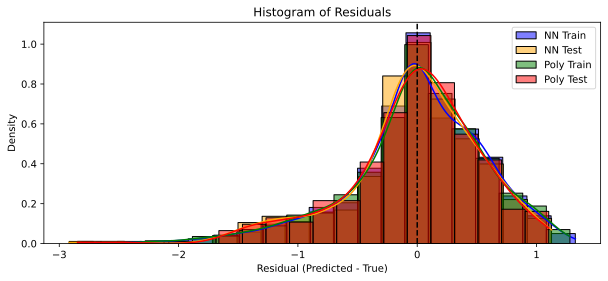

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro

# Assume diagnostics is already defined and populated
# We'll now define the plotting code using it

figures = {}

# 1. Histogram of Residuals
plt.figure(figsize=(10, 4))
sns.histplot(diagnostics["NN"]["train"]["residuals"], bins=20, kde=True, color='blue', label='NN Train', stat='density')
sns.histplot(diagnostics["NN"]["test"]["residuals"], bins=20, kde=True, color='orange', label='NN Test', stat='density')
sns.histplot(diagnostics["poly"]["train"]["residuals"], bins=20, kde=True, color='green', label='Poly Train', stat='density')
sns.histplot(diagnostics["poly"]["test"]["residuals"], bins=20, kde=True, color='red', label='Poly Test', stat='density')
plt.axvline(0, color='k', linestyle='--')
plt.title("Histogram of Residuals")
plt.xlabel("Residual (Predicted - True)")
plt.legend()
figures["Histogram of Residuals"] = plt.gcf()
plt.savefig("assets/Dfig03.svg", format='svg', dpi=300)
plt.show()


### Residual vs predicted

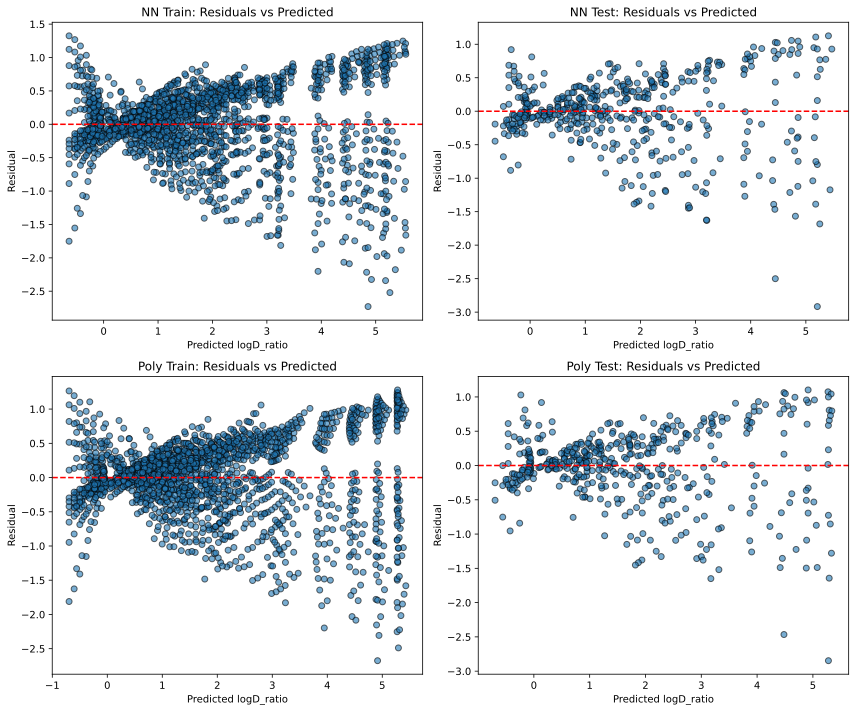

In [42]:
# 2. Residuals vs Predicted
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
models = ["NN", "poly"]
datasets = ["train", "test"]
titles = [["NN Train", "NN Test"], ["Poly Train", "Poly Test"]]

for i, model in enumerate(models):
    for j, dataset in enumerate(datasets):
        ax[i, j].scatter(
            diagnostics[model][dataset]["predicted"],
            diagnostics[model][dataset]["residuals"],
            alpha=0.6, edgecolor='k'
        )
        ax[i, j].axhline(0, color='r', linestyle='--')
        ax[i, j].set_title(f"{titles[i][j]}: Residuals vs Predicted")
        ax[i, j].set_xlabel("Predicted logD_ratio")
        ax[i, j].set_ylabel("Residual")

plt.tight_layout()
figures["Residuals vs Predicted"] = plt.gcf()
plt.savefig("assets/Dfig04.svg", format='svg', dpi=300)
plt.show()

### QQ Plots

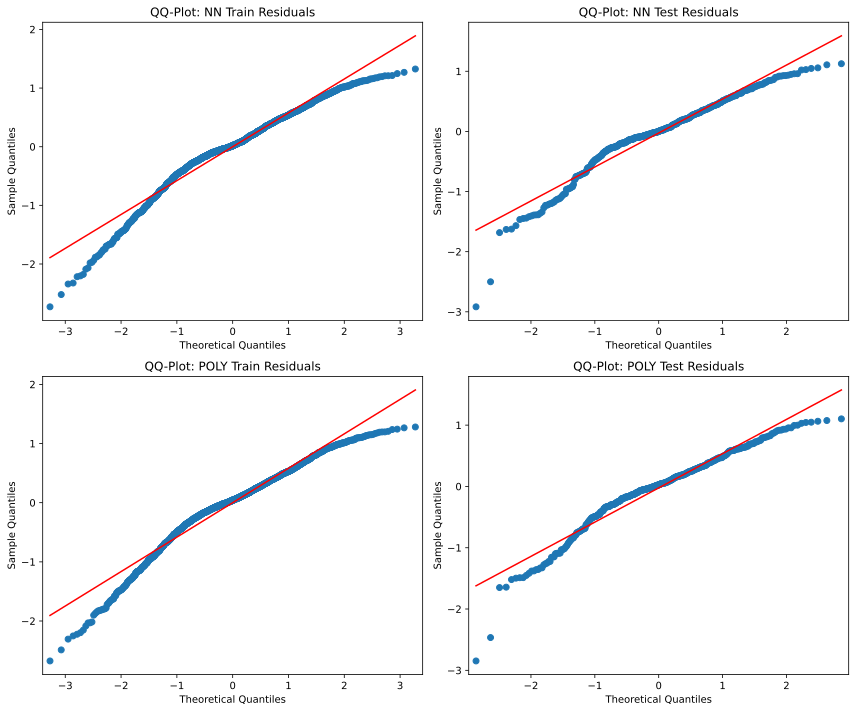

In [43]:
# 3. QQ-Plot
fig = plt.figure(figsize=(12, 10))
for i, model in enumerate(models):
    for j, dataset in enumerate(datasets):
        ax = fig.add_subplot(2, 2, i*2 + j + 1)
        sm.qqplot(diagnostics[model][dataset]["residuals"], line='s', ax=ax)
        ax.set_title(f'QQ-Plot: {model.upper()} {dataset.title()} Residuals')
plt.tight_layout()
figures["QQ Plot"] = fig
plt.savefig("assets/Dfig05.svg", format='svg', dpi=300)
plt.show()

### Shapiro-Wilk Tests

In [57]:
# 4. Shapiro-Wilk Tests
shapiro_results = {
    (model, dataset): shapiro(diagnostics[model][dataset]["residuals"])
    for model in diagnostics for dataset in diagnostics[model]
}

shapiro_summary = {
    f"{model.upper()} {dataset.title()}": {
        "model":model,
        "dataset":dataset,
        "W": result.statistic,
        "p-value": result.pvalue
    }
    for (model, dataset), result in shapiro_results.items()
}


df_shapiro = pd.DataFrame(shapiro_summary).T
html_table = df_shapiro.to_html(index=False, escape=False, classes="table table-striped", border=0)
display(HTML(html_table))
#print(html_table)

figures.keys()  # Return list of generated figure titles

model,dataset,W,p-value
NN,train,0.962,1.05e-21
NN,test,0.948,7.42e-12
poly,train,0.962,6.96e-22
poly,test,0.951,1.94e-11


dict_keys(['Histogram of Residuals', 'Residuals vs Predicted', 'QQ Plot', 'NN vs Poly Predicted'])

### Predicted NN vs Poly

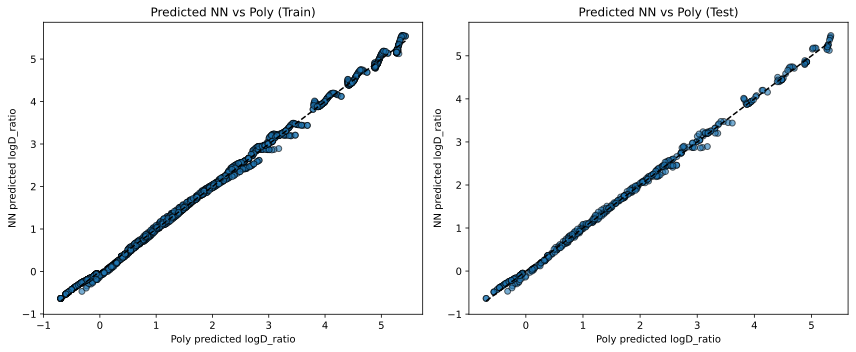

In [52]:
# 5. Predicted NN vs Poly
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for j, dataset in enumerate(datasets):
    ax[j].scatter(
        diagnostics["poly"][dataset]["predicted"],
        diagnostics["NN"][dataset]["predicted"],
        alpha=0.6, edgecolor='k'
    )
    ax[j].plot(
        [min(diagnostics["poly"][dataset]["predicted"]), max(diagnostics["poly"][dataset]["predicted"])],
        [min(diagnostics["poly"][dataset]["predicted"]), max(diagnostics["poly"][dataset]["predicted"])],
        'k--'
    )
    ax[j].set_title(f'Predicted NN vs Poly ({dataset.title()})')
    ax[j].set_xlabel("Poly predicted logD_ratio")
    ax[j].set_ylabel("NN predicted logD_ratio")

plt.tight_layout()
figures["NN vs Poly Predicted"] = plt.gcf()
plt.savefig("assets/Dfig06.svg", format='svg', dpi=300)
plt.show()

---
## 7. 📉 Dimensionality Reduction and Scaling Structure

We apply **PCA on the contrastive input space** to identify dominant modes and assess feature redundancy:


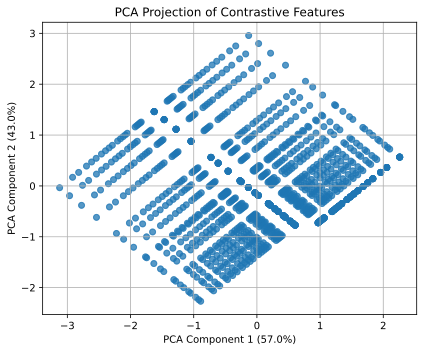

In [56]:
# fast PCA on inputs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_proj = pca.fit_transform(X_scaled)
# Extract explained variance
expl_var = pca.explained_variance_ratio_ * 100  # in percent


plt.figure(figsize=(6, 5))
plt.scatter(X_proj[:, 0], X_proj[:, 1], alpha=0.5)
plt.xlabel(f'PCA Component 1 ({expl_var[0]:.1f}%)')
plt.ylabel(f'PCA Component 2 ({expl_var[1]:.1f}%)')
plt.title('PCA Projection of Contrastive Features')
plt.grid(True)
plt.tight_layout()
plt.savefig("assets/Dfig08.svg", format='svg', dpi=300)
plt.show()


📌 This reveals:

- Polynomial nonlinearity captured by NN

- Clusters driven by polymer type or $T_g$
- Orthogonality between $\log(M_i/M_j)$ and $1/T_i - 1/T_j$
- Regions where contrastive predictions may be unstable

👉 Consider also **PCoA** on a log-transformed contrastive distance matrix when the dataset violates Euclidean assumptions.

---

## 8. 🧩 Hybrid Methodology & Scaling Laws

**Contrastive GS** bridges:

| Symbolic Kernels                        | Deep Learning Inference  |
| --------------------------------------- | ------------------------ |
| Known physics ($D \propto M^{-\alpha}$) | Hidden structure in data |
| Few interpretable parameters            | High-capacity estimators |

🔗 **Vaschy-Buckingham $\pi$-theorem** provides a theoretical basis for using invariant ratios in log-space.

🧠 Neural networks extract these invariant manifolds from contrastive pairs without ever seeing absolute quantities.

📐 Sparse Additive Models (e.g., Lasso) may also be used to impose partial structure.

------

## ✅ Conclusion

This case study demonstrates that **contrastive training** can:

- Recover physically meaningful **scaling laws** from partial data
- Yield generalizable, nonlinear predictors
- Be validated against symbolic models and diagnostics

Contrastive GS provides a robust framework for learning in **simulation-scarce**, **data-structured**, and **physics-informed** environments.

------

## ⚙️ Appendix: Execution Environment

- PyTorch with CUDA 12.4
- scikit-learn, seaborn, matplotlib
- Fully reproducible on local GPU or CPU